In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")

--2021-01-25 16:08:19--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.187.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-01-25 16:08:19 (75.7 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
corpus[:2]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,"]

In [5]:
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [16]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1)) # Your Embedding Layer
model.add(LSTM(128, return_sequences=True)) # An LSTM Layer
model.add(Dropout(0.2)) # A dropout layer
model.add(LSTM(64)) # Another LSTM Layer
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))) # A Dense Layer including regularizers
model.add(Dense(total_words, activation='softmax')) # A Dense Layer
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.003), metrics=['accuracy']) # Pick a loss function and an optimizer
print(model.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
lstm_12 (LSTM)               (None, 10, 128)           117248    
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 3211)              208715    
Total params: 700,631
Trainable params: 700,631
Non-trainable params: 0
________________________________________________

In [17]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 11s 16ms/step - loss: 7.1773 - accuracy: 0.0199
Epoch 2/100
484/484 [==============================] - 8s 16ms/step - loss: 6.5570 - accuracy: 0.0226
Epoch 3/100
484/484 [==============================] - 8s 16ms/step - loss: 6.4637 - accuracy: 0.0217
Epoch 4/100
484/484 [==============================] - 8s 16ms/step - loss: 6.3677 - accuracy: 0.0286
Epoch 5/100
484/484 [==============================] - 8s 16ms/step - loss: 6.2974 - accuracy: 0.0292
Epoch 6/100
484/484 [==============================] - 8s 16ms/step - loss: 6.1967 - accuracy: 0.0272
Epoch 7/100
484/484 [==============================] - 8s 16ms/step - loss: 6.1283 - accuracy: 0.0310
Epoch 8/100
484/484 [==============================] - 8s 16ms/step - loss: 6.0673 - accuracy: 0.0352
Epoch 9/100
484/484 [==============================] - 8s 16ms/step - loss: 6.0034 - accuracy: 0.0399
Epoch 10/100
484/484 [==============================] - 8s 16ms/step - loss: 5.92

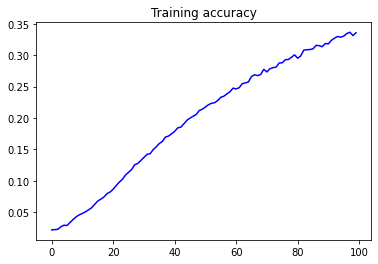

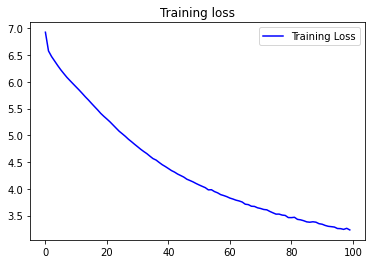

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [19]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope and die before stay new grow ' upon abuse thee alone is women's night or woe thoughts replete so 'will ' must grow grown ' increase born quite gone got of hell false broken outstripp'd than beauty blot of every hand pride control not well of use truth night more ill scope by deceive blood shaken knights mark forsworn so well old world possess'd so 'will ' or rich got more up more hide of thee is confounds men will was thee dies so true young every brow holds it still more skill increase memory spends truth twain rare hell
